# Data Wrangling and Cleaning
This notebook investigates the raw and partially processed datasets. 

# Orders Dataset

## Cleaning

Cleaning steps are refactored into "belly_rubb_analysis/dataset.py". These include:
    - Enforcing correct datatypes found in "docs/datatypes/".
    - Dropping columns with more than 70% missing values.
    - Dropping duplicate rows.
    - Dropping columns with a constant value.

In [97]:
import os
import pandas as pd

# Data Visualization
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Helper functions
from belly_rubb_analysis.dataset import calculate_upper_bound

# Configuration info
%load_ext autoreload
%autoreload 1
%aimport belly_rubb_analysis.config
from belly_rubb_analysis.config import INTERIM_DATA_DIR, RAW_DATA_DIR, PROFILE_REPORTS_DIR, FIGURES_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
orders_df = pd.read_csv(INTERIM_DATA_DIR / 'orders-2023-12-22-2024-12-20.csv')

orders_df.head()

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
0,Uber Eats Delivery A97C3,2024-12-20,48.99,4.65,53.64,2024-12-20 13:25:00,Pickup,Completed,Postmates Delivery,A97C3-Olga G.,NaN,+1 312-766-6835,1,BEEF BACK RIBS (Full Rack),Regular,1 x Signature BBQ Glaze,48.99,48.99,53.64
1,Uber Eats Delivery 86B6C,2024-12-19,40.12,3.81,43.93,2024-12-19 18:40:00,Pickup,Completed,Postmates Delivery,86B6C-Martin T.,NaN,+1 312-766-6835,1,LOADED FRIES,Regular,"1 x No Cheddar, 1 x No Provolone, 1 x Signatur...",11.99,22.18,24.29
2,Uber Eats Delivery 86B6C,2024-12-19,40.12,3.81,43.93,2024-12-19 18:40:00,Pickup,Completed,Postmates Delivery,86B6C-Martin T.,NaN,+1 312-766-6835,1,CHICKEN WINGS,6 pcs,1 x Sweet&Spicy glaze (Pairs well w/ LemonPeep...,17.94,17.94,19.64
3,Uber Eats Delivery 1B73A,2024-12-19,32.19,3.06,35.25,2024-12-19 14:59:00,Pickup,Completed,Postmates Delivery,1B73A-Diana O.,NaN,+1 312-766-6835,1,CIABATTA STEAK SANDWICH,Regular,NaN,19.45,19.45,21.30
4,Uber Eats Delivery 1B73A,2024-12-19,32.19,3.06,35.25,2024-12-19 14:59:00,Pickup,Completed,Postmates Delivery,1B73A-Diana O.,NaN,+1 312-766-6835,1,LOADED FRIES,Regular,"1 x Blue Cheese Sauce Drizzle, 1 x Salt and Pe...",11.99,12.74,13.95


In [4]:
# Generate initial report of orders.csv

if not os.path.exists(PROFILE_REPORTS_DIR / 'orders-profile-report.html'):
    profile = ProfileReport(orders_df, title='Orders Profiling Report')
    profile.to_file('./../reports/profile-reports/orders-profile-report.html')

In [5]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order                     1413 non-null   object 
 1   Order Date                1414 non-null   object 
 2   Order Subtotal            1414 non-null   float64
 3   Order Tax Total           1414 non-null   float64
 4   Order Total               1414 non-null   float64
 5   Fulfillment Date          1414 non-null   object 
 6   Fulfillment Type          1414 non-null   object 
 7   Fulfillment Status        1414 non-null   object 
 8   Channels                  1414 non-null   object 
 9   Recipient Name            1414 non-null   object 
 10  Recipient Email           1073 non-null   object 
 11  Recipient Phone           1414 non-null   object 
 12  Item Quantity             1414 non-null   int64  
 13  Item Name                 1413 non-null   object 
 14  Item Var

## Missing Values

Although columns with more than 70% missing values were dropped, there are a few left with considerable missingness. These include:

    - `Recipient Email`: 23.8% missing
    - `Order`: 0.1% missing
    - `Item Name`: 0.1% missing
    - `Item Variation`: 0.1% missing
    - `Item Modifiers`: 40.5% missing

These will be investigated for any patterns.

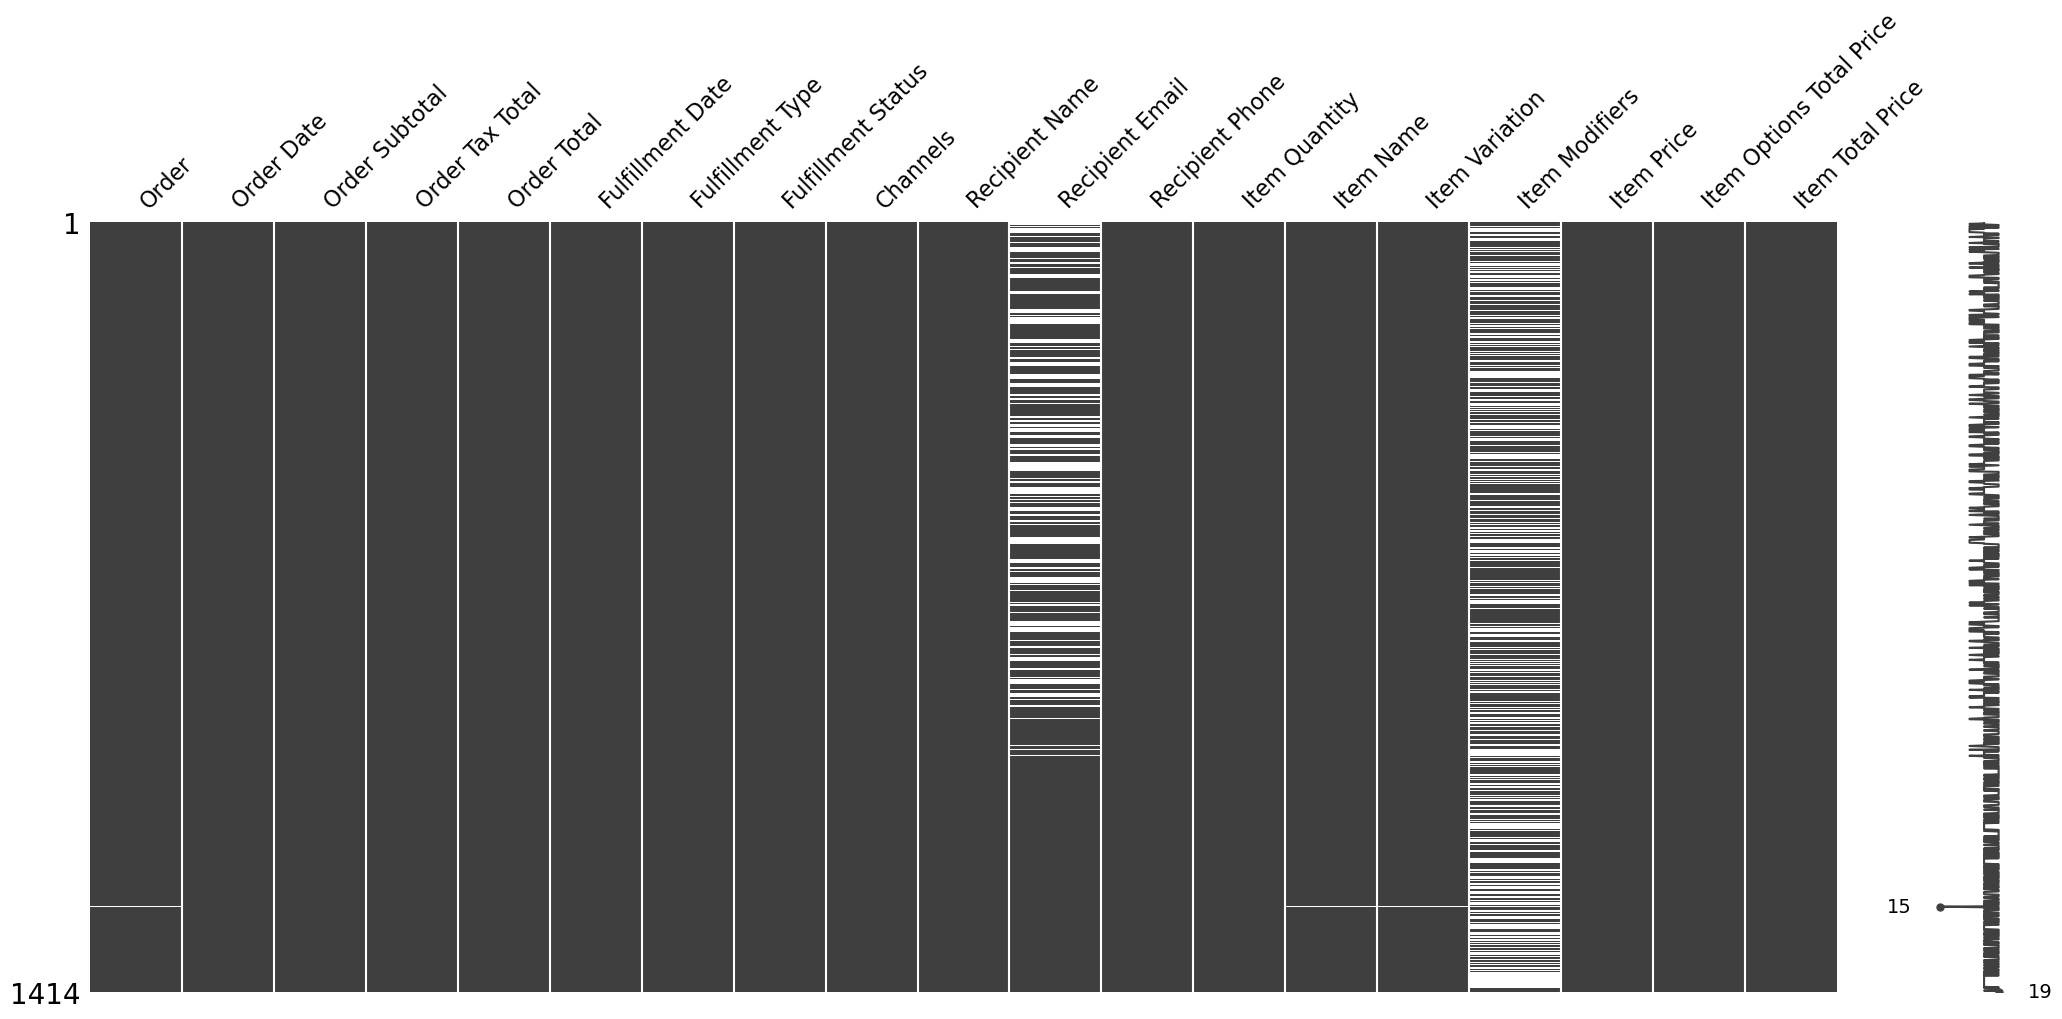

In [6]:
# Visualize missingness matrix

msno.matrix(orders_df)

plt.show()

### Order, Item Name, and Item Variation

There is one row which has missing values between Order, Item Name, Item Variation, and possibly Item Modifiers. We will investigate this row to understand the cause.

In [7]:
# Pull up single row with a missing value in Order

orders_df[orders_df['Order'].isna()]

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
1256,NaN,2024-03-07,450.0,42.75,512.75,2024-03-07 16:14:00,Other,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,1,NaN,NaN,NaN,450.0,450.0,492.75


Looks like this row is missing information about the items ordered as well. This could have been an order for a family member or friend, catering event, or cash which was entered into the system later.

### Item Modifiers

This column is missing 40.5% of its values. This is most likely due to the fact that this is an optional field for customers to enter personalized modifications when ordering. Just to be sure we'll see if there's a pattern to this missingness.

In [8]:
# Investigate values in Item Modifiers

orders_df['Item Modifiers'].unique()

array(['1 x Signature BBQ Glaze',
       '1 x No Cheddar, 1 x No Provolone, 1 x Signature BBQ Sauce Drizzle, 1 x Sweet and Spicy BBQ Sauce Dip, 1 x Lemon Pepper, 1 x Add Pork Rib Meat (Of-The-Bone!)',
       '1 x Sweet&Spicy glaze (Pairs well w/ LemonPeeper seasoning), 1 x Zesty Lemon Pepper',
       nan, '1 x Blue Cheese Sauce Drizzle, 1 x Salt and Pepper',
       '1 x Sweet&Spicy Glaze, 1 x Please, cut it!',
       '1 x Add gorgonzola! Make it special.',
       '1 x Please, cut it!, 1 x Signature BBQ Glaze',
       '1 x Signature BBQ Sauce Drizzle, 1 x Salt and Pepper',
       '1 x Lemon Pepper',
       '1 x Sprite ™, 1 x Mac & Cheese, 1 x Rosemary Pepper Fries, 1 x Sweet&Spicy Glaze, 1 x Boom-Boom Sauce DIp',
       '1 x Boom-Boom Sauce DIp, 1 x Sweet and Spicy BBQ Sauce Dip',
       '1 x Sweet and Spicy BBQ Sauce Dip, 1 x Pickled Jalapeño Peppers',
       '1 x Signature BBQ Glaze, 1 x Signature BBQ Sauce Dip',
       '1 x Rosemary Pepper',
       '1 x Salt&Pepper, 1 x Sweet&Spicy g

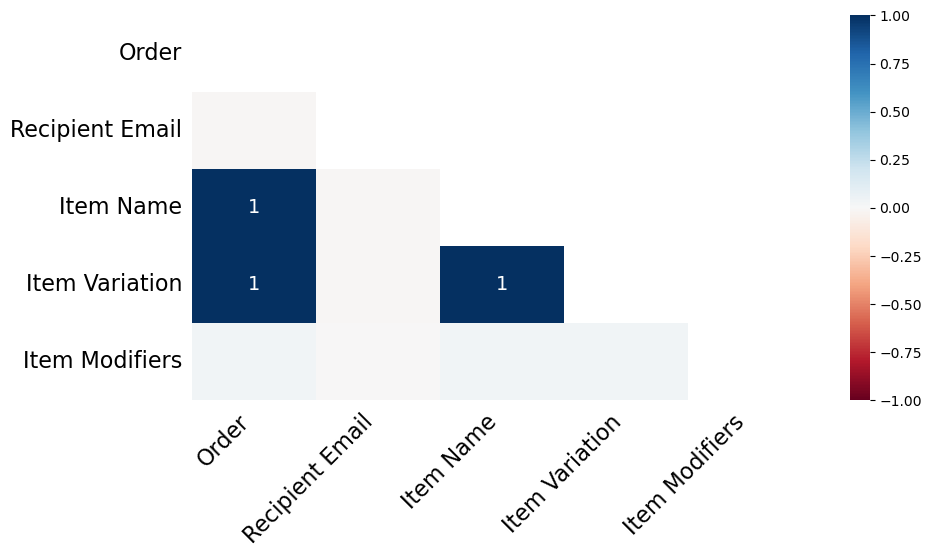

In [9]:
# Visualize missingness correlation

msno.heatmap(orders_df, figsize=(10,5))

plt.show()

The perfectly correlated features come from the single row which had all of those missing. Otherwise, there are no significant missingness correlations.

In [10]:
orders_df[orders_df['Item Modifiers'].isna()]

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
3,Uber Eats Delivery 1B73A,2024-12-19,32.19,3.06,35.25,2024-12-19 14:59:00,Pickup,Completed,Postmates Delivery,1B73A-Diana O.,NaN,+1 312-766-6835,1,CIABATTA STEAK SANDWICH,Regular,NaN,19.45,19.45,21.30
7,Postmates Delivery EAA45,2024-12-19,22.06,1.20,23.26,2024-12-19 11:26:00,Pickup,Completed,Postmates Delivery,EAA45-Anthony S.,NaN,+1 312-766-6835,1,PINEAPPLE SLAW,Full,NaN,9.46,9.46,9.46
8,Postmates Delivery EAA45,2024-12-19,22.06,1.20,23.26,2024-12-19 11:26:00,Pickup,Completed,Postmates Delivery,EAA45-Anthony S.,NaN,+1 312-766-6835,1,ARTISAN MAC AND CHEESE,Full,NaN,12.60,12.60,13.80
11,Uber Eats Delivery 8F819,2024-12-18,37.90,3.46,41.36,2024-12-18 13:58:00,Pickup,Completed,Postmates Delivery,8F819-Diana O.,NaN,+1 312-766-6835,1,CRISPY CHICKEN SANDWICH,Regular,NaN,16.46,16.46,18.02
13,Uber Eats Delivery 8F819,2024-12-18,37.90,3.46,41.36,2024-12-18 13:58:00,Pickup,Completed,Postmates Delivery,8F819-Diana O.,NaN,+1 312-766-6835,1,CREAMY BLUE CHEESE DIP,Regular,NaN,1.45,1.45,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,DOORDASH,2024-01-05,31.97,2.28,34.25,2024-01-05 15:12:00,Pickup,Completed,DoorDash,Brandon K,point-of-sale-integration@doordash.com,8559731040,1,GET YOUR BABY BACK!,Half rack,NaN,23.99,23.99,25.70
1402,DOORDASH,2024-01-05,20.81,1.98,22.79,2024-01-05 13:49:00,Pickup,Completed,DoorDash,Timothy L,point-of-sale-integration@doordash.com,8559731040,1,MAC&CHEESE,Side,NaN,4.99,4.99,5.46
1403,DOORDASH,2024-01-05,20.81,1.98,22.79,2024-01-05 13:49:00,Pickup,Completed,DoorDash,Timothy L,point-of-sale-integration@doordash.com,8559731040,1,CRINKLE FRIES,"Side, Rosemary pepper",NaN,4.99,4.99,5.47
1405,DOORDASH,2024-01-04,35.37,2.60,37.97,2024-01-04 17:31:00,Pickup,Completed,DoorDash,Benjamin B,point-of-sale-integration@doordash.com,8559731040,1,GRILLED SWEET CORN,Regular,NaN,2.99,2.99,3.21


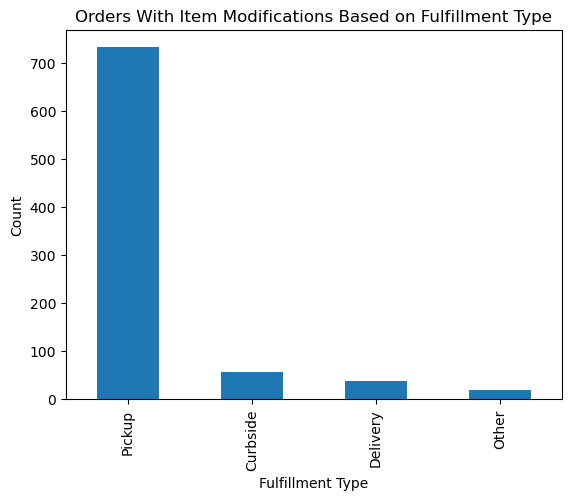

In [11]:
# Visualize relationship between item modifications and fulfillment type

orders_df.groupby(by='Fulfillment Type')['Item Modifiers'].count().sort_values(ascending=False).plot(kind='bar')

plt.title('Orders With Item Modifications Based on Fulfillment Type')
plt.ylabel('Count')
plt.xlabel('Fulfillment Type')

plt.savefig(FIGURES_DIR / 'bar_fulfillment_type_item_modifiers_count.png', bbox_inches='tight')
plt.show()

Orders with modifications are primarily pickup orders.

### Recipient Email

This column is missing 23.8% of its values, so we'll investigate this as well. Most likely this is also a customer preference.

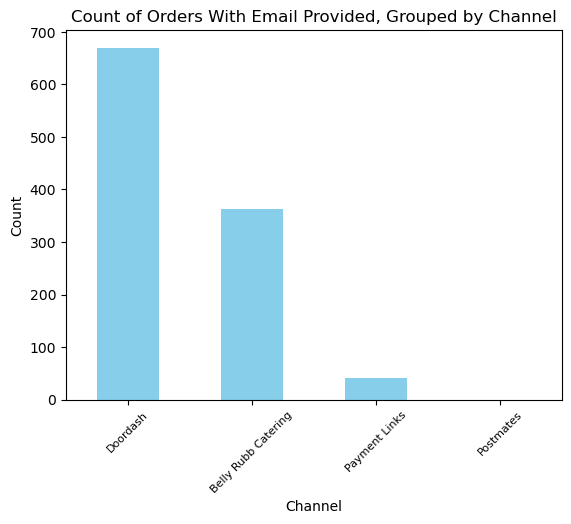

In [12]:
# Visualize count of whose emails were included based on Channel they ordered from

orders_df.groupby(by='Channels')['Recipient Email'].count().sort_values(ascending=False).plot(kind='bar', color='skyblue')

channel_labels = ['Doordash', 'Belly Rubb Catering', 'Payment Links', 'Postmates']

plt.title('Count of Orders With Email Provided, Grouped by Channel')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.xticks(range(len(channel_labels)), labels=channel_labels, rotation=45, fontsize=8)

plt.savefig(FIGURES_DIR / 'bar_email_channel_counts.png', bbox_inches='tight')
plt.show()

It looks like ordering through Postmates does not share customer emails. If emails are important for customer outreach and advertising, perhaps this can be changed.

## Correlations
Some columns are heavily correlated with each other according to the [profile report](/home/arsen/Documents/dsc_projects/belly_rubb_analysis/reports/profile-reports/orders-profile-report.html).

### Channels and Fulfillment Type

In [13]:
fulfillment_set = set(orders_df['Fulfillment Type'])
channels_set = set(orders_df['Channels'])
print(f"Difference: {fulfillment_set.difference(channels_set)}")
print(f"Union: {fulfillment_set.union(channels_set)}")

Difference: {'Pickup', 'Delivery', 'Other', 'Curbside'}
Union: {'Pickup', 'Delivery', 'Postmates Delivery', 'BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery', 'Curbside', 'DoorDash', 'Other', 'Payment Links'}


In [14]:
# View combinations of fulfillment type and channels

orders_df[['Fulfillment Type', 'Channels']].drop_duplicates()

,Fulfillment Type,Channels
0,Pickup,Postmates Delivery
5,Pickup,BELLY RUBB | BBQ Catering | Barbecue To Go and...
9,Pickup,DoorDash
63,Other,Payment Links
68,Curbside,BELLY RUBB | BBQ Catering | Barbecue To Go and...
109,Delivery,BELLY RUBB | BBQ Catering | Barbecue To Go and...
1256,Other,BELLY RUBB | BBQ Catering | Barbecue To Go and...


It looks like delivery orders have only been placed through the kitchen website. There is a chance, however, that a `Pickup` fulfillment type doesn't necessarily mean that it was picked up by the customer. It could potentially indicate that it was picked up by a delivery driver.

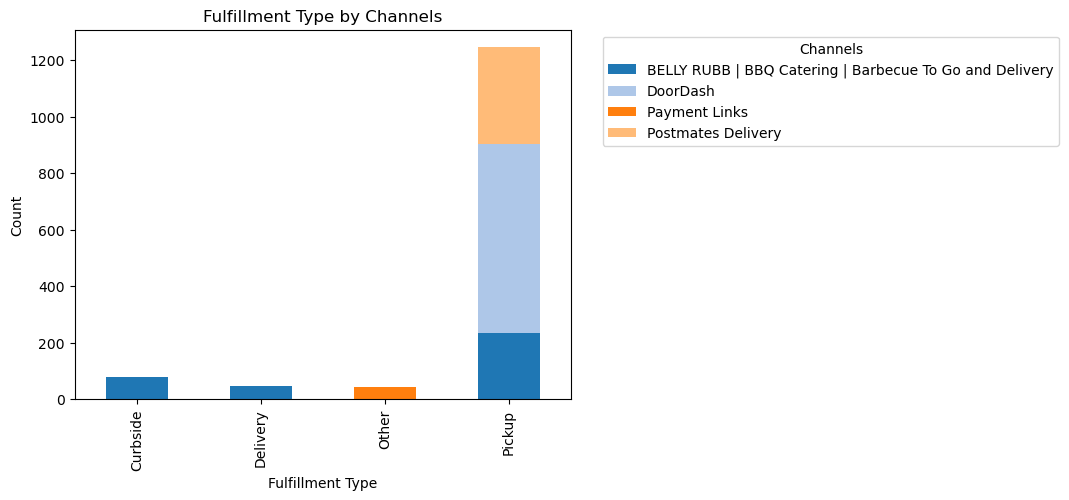

In [15]:
# Visualize how Channels are distributed amongst Fulfillment Types

fulfillment_channels_counts = orders_df.groupby(['Fulfillment Type', 'Channels']).size().unstack(fill_value=0)
fulfillment_channels_counts.plot(
    kind='bar',
    stacked=True,
    color=plt.cm.tab20.colors,
)

plt.title('Fulfillment Type by Channels')
plt.ylabel('Count')
plt.xlabel('Fulfillment Type')
plt.legend(title='Channels', bbox_to_anchor=(1.05, 1))

plt.savefig(FIGURES_DIR / 'stacked_bar_fulfillment_type_channels.png', bbox_inches='tight')
plt.show()

It appears like a majority of orders are labelled as Pickup. This will need to be verified, but it's most likely that Postmates and DoorDash label orders 'picked up' by a delivery driver as such. This is most likely causing the high correlation since all Postmates and Doordash Channels are also Fulfillment type Pickup.

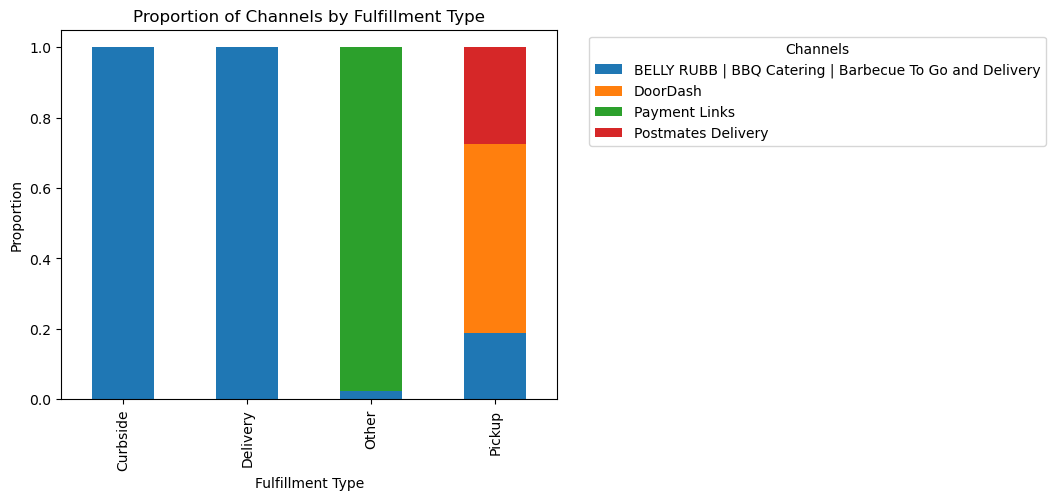

In [16]:
# Visualize proportion of channels by fulfillment type

fullfillment_proportions = fulfillment_channels_counts.div(fulfillment_channels_counts.sum(axis=1), axis=0)
fullfillment_proportions.plot(
    kind='bar',
    stacked=True
)

plt.title('Proportion of Channels by Fulfillment Type')
plt.legend(title='Channels', bbox_to_anchor=(1.05, 1))
plt.xlabel('Fulfillment Type')
plt.ylabel('Proportion')

plt.show()

This visualization verifies that all Curbside and Delivery orders are made through Belly Rubb, that a huge majoriy of Other types are Payment links, and that all Doordash and Postmates orders are Pickup Fulfillment type.

### Channels and Item Options Total Price

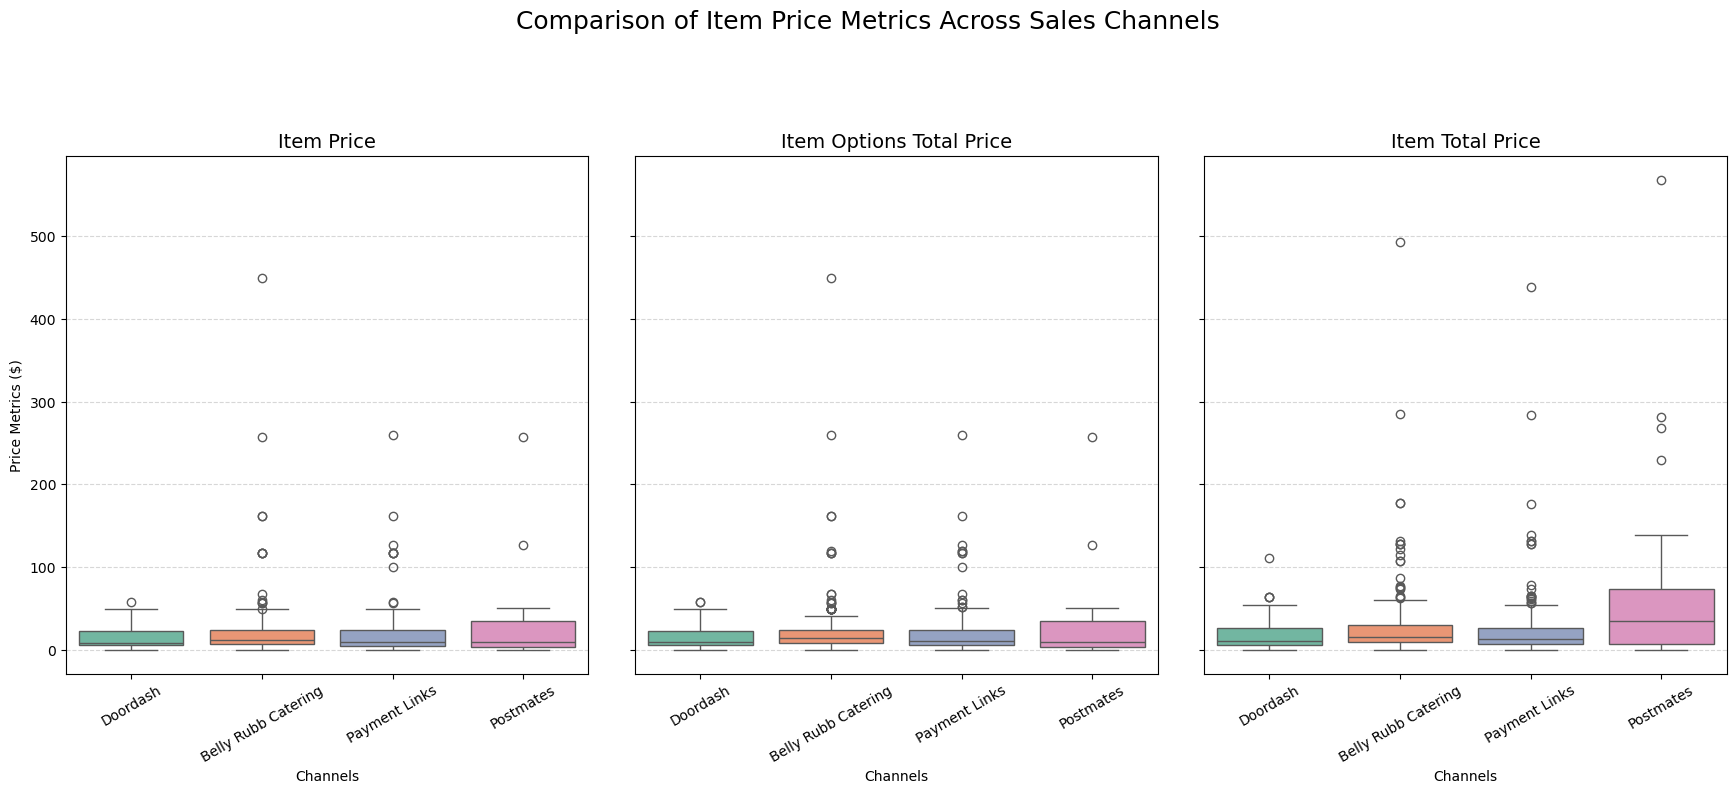

In [62]:
# Visualize relationship between Channels and the different item price metrics

fig, ax = plt.subplots(1, 3, figsize=(18,8), sharey=True)

# Common boxplot features
boxplot_params = {
    'data': orders_df,
    'x': 'Channels',
    'hue': 'Channels',
    'palette': 'Set2'
}

# First boxplot
sns.boxplot(
    y='Item Price',
    ax=ax[0],
    **boxplot_params)

ax[0].set_xticks(range(len(channel_labels)), labels=channel_labels, rotation=30, fontsize=10)
ax[0].set_title('Item Price', fontsize=14)
ax[0].grid(axis='y', linestyle='--', alpha=0.5)

# Second boxplot
sns.boxplot(
    y='Item Options Total Price',
    ax=ax[1],
    **boxplot_params)

ax[1].set_xticks(range(len(channel_labels)), labels=channel_labels, rotation=30, fontsize=10)
ax[1].set_title('Item Options Total Price', fontsize=14)
ax[1].grid(axis='y', linestyle='--', alpha=0.5)

# Third boxplot
sns.boxplot(
    y='Item Total Price',
    ax=ax[2],
    **boxplot_params)

ax[2].set_xticks(range(len(channel_labels)), labels=channel_labels, rotation=30, fontsize=10)
ax[2].set_title('Item Total Price', fontsize=14)
ax[2].grid(axis='y', linestyle='--', alpha=0.5)

# Shared elements
fig.suptitle('Comparison of Item Price Metrics Across Sales Channels', fontsize=18, y=1.02)
ax[0].set_ylabel('Price Metrics ($)')
fig.tight_layout(pad=3.0)

plt.savefig(FIGURES_DIR / 'box_price_metrics_sales_channels.png', bbox_inches='tight')
plt.show()

A few conclusions can be made from these figures:

    - While most of the price, options total price, and total price are concentrated in the $0-50 range, there are some extreme outliers. Doordash contains the fewest outliers, while orders through Belly Rubb have the most.
    - Across channels prices prices are right skewed.
    - The overall increase in prices in Postemates Item Total Price is unexpected.
    - It's clear that there's a correlation between the three pricing columns, explaining the high correlation between them. Since they are linked to a channel, this also explains the correlation with the Channels columns.

## Outliers

We discovered some outliers in our previous exploratory steps which will need to be investigated to understand if there are entry errors or not.

### Postmates Item Total Price
This will look at the outliers in the Total Price ordered through Postmates Delivery channel.

In [98]:
# Calculate upper bound based on iqr

upper_bound = calculate_upper_bound(orders_df, 'Item Total Price')

postmates_outliers = orders_df[(orders_df['Item Total Price'] > upper_bound) & (orders_df['Channels'] == 'Postmates Delivery')]
postmates_outliers

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
15,Uber Eats Delivery 7751A,2024-12-17,113.09,10.74,123.83,2024-12-17 19:56:00,Pickup,Completed,Postmates Delivery,7751A-Lilit A.,NaN,+1 312-766-6835,3,BEEF SHORT RIB,Regular,NaN,33.95,33.95,111.52
160,Uber Eats Delivery DA32F,2024-11-23,89.79,8.53,98.32,2024-11-23 18:30:00,Pickup,Completed,Postmates Delivery,DA32F-Jamie M.,NaN,+1 312-766-6835,1,RIBS & WINGS BUNDLE,Regular,"1 x Sweet&Spicy Glaze, 1 x Signature BBQ glaze...",57.99,57.99,63.50
555,Uber Eats Pickup F7D64,2024-09-27,58.35,5.54,63.89,2024-09-27 14:15:00,Pickup,Completed,Postmates Delivery,F7D64-RENA J.,NaN,+1 312-766-6835,3,CIABATTA STEAK SANDWICH,Regular,NaN,19.45,19.45,63.89
744,Postmates Delivery F63ED,2024-08-23,86.76,8.24,95.00,2024-08-23 17:39:00,Pickup,Completed,Postmates Delivery,F63ED-Barry S.,NaN,+1 312-766-6835,1,SHORT RIB PLATTER,Regular,1 x Add Full-size Pineapple Slaw,49.54,58.05,63.56


In [79]:
# Find all orders by these individuals

outliers_names = postmates_outliers['Recipient Name']
outlier_orders = orders_df[orders_df['Recipient Name'].isin(outliers_names)]

outlier_orders.groupby(by=['Order', 'Recipient Name'])['Item Total Price'].sum()

Order                     Recipient Name
Postmates Delivery F63ED  F63ED-Barry S.     95.00
Uber Eats Delivery 7751A  7751A-Lilit A.    123.83
Uber Eats Delivery DA32F  DA32F-Jamie M.     98.32
Uber Eats Pickup F7D64    F7D64-RENA J.      63.89
Name: Item Total Price, dtype: float64

It looks like these were on time orders by these individuals, however we should also check if they placed orders using other Channels, which may result in their Recipient Name being stored differently.

In [94]:
# Find all orders regardless of how their name is stored

cleaned_names = postmates_outliers['Recipient Name'].str.slice(6,-1)
outlier_orders = orders_df[orders_df['Recipient Name'].apply(lambda x: any(name in x for name in cleaned_names))]

outlier_orders.groupby(by=['Recipient Name'])['Item Total Price'].sum()

Recipient Name
3230D-Jamie M.     17.28
7751A-Lilit A.    123.83
9B66C-Jamie M.     24.01
A23C8-Jamie M.     24.88
C5503-RENA J.      22.38
DA32F-Jamie M.     98.32
F63ED-Barry S.     95.00
F7D64-RENA J.      63.89
Name: Item Total Price, dtype: float64

It looks like Jamie M and Rena J did order multiple times. However, they still only placed such high orders only once.

### Payment Links Item Total Price
Here we will investigate the outliers in the Payment Links channel.

In [101]:
# Get outliers from Payment Links channel

payment_links_outliers = orders_df[(orders_df['Item Total Price'] > upper_bound) & (orders_df['Channels'] == 'Payment Links')]
payment_links_outliers.head()

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
63,Payment Link,2024-12-11,147.00,12.06,159.06,2024-12-11 13:51:00,Other,Completed,Payment Links,Grikor Odjakhian,grikorodjakhian@gmail.com,+18189138445,1,Party Package (4-6 ppl),Regular,"1 x No glaze, 1 x Black Truffle Salt, 1 x Swee...",127.00,127.00,139.06
269,Payment Link,2024-11-07,318.67,30.27,363.94,2024-11-08 11:55:00,Other,Completed,Payment Links,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,2,GLAZED BABY BACK PORK RIBS,Full Rack,1 x Sweet&Spicy Glaze,34.93,34.93,76.50
270,Payment Link,2024-11-07,318.67,30.27,363.94,2024-11-08 11:55:00,Other,Completed,Payment Links,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,3,GLAZED BABY BACK PORK RIBS,Full Rack,1 x Signature BBQ Glaze,34.93,34.93,114.74
273,Payment Link,2024-11-07,318.67,30.27,363.94,2024-11-08 11:55:00,Other,Completed,Payment Links,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,14,GRILLED SWEET CORN,Regular,NaN,3.99,3.99,61.17
303,Payment Link,2024-11-01,461.07,43.80,504.87,2024-11-03 14:45:00,Other,Completed,Payment Links,Tiffany Tapia,strwbrytiff@yahoo.com,+18185715969,1,Party Package (10-12 ppl),Regular,"1 x Salt & Pepper, 1 x Signature BBQ Glaze, 1 ...",257.00,257.00,281.41


In [102]:
# See who is ordering using this channel

payment_links_outliers.groupby(by=['Recipient Name'])['Item Total Price'].sum()

Recipient Name
Grikor Odjakhian     139.06
Levon Safaryan      1686.18
Tiffany Tapia        357.91
Name: Item Total Price, dtype: float64

In [107]:
# Find other orders by these recipients

outlier_recipients = payment_links_outliers['Recipient Name'].unique()
orders_df[orders_df['Recipient Name'].isin(outlier_recipients)]['Channels'].unique()

array(['Payment Links',
       'BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery'],
      dtype=object)

In [122]:
# Get outlier first names and search df using that

outlier_names = [recipient.split(' ')[0] for recipient in outlier_recipients]
outlier_orders = orders_df[orders_df['Recipient Name'].apply(lambda x: any(name in x for name in outlier_names))]

outlier_orders.groupby(by=['Recipient Name', 'Channels'])['Item Total Price'].sum()

Recipient Name    Channels                                               
Grikor Odjakhian  Payment Links                                               159.06
Levon Safaryan    BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery     492.75
                  Payment Links                                              1880.08
Tiffany Nguyen    BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery      46.70
Tiffany Tapia     Payment Links                                               504.87
Name: Item Total Price, dtype: float64

It looks like payment links remain the popular choice for the outliers in this group. Levon is the only one who has also ordered through the Belly Rubb website.

### Belly Rubb Website Channels Item Total Price
Here we investigate outliers in the Belly Rubb website channel.

In [123]:
belly_rubb_outliers = orders_df[(orders_df['Item Total Price'] > upper_bound) & (orders_df['Channels'] == 'BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery')]
belly_rubb_outliers.head()

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
114,Square Online 1423154768,2024-11-28,67.99,6.46,90.24,2024-11-28 15:35:00,Delivery,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,paola munoz,pmunoz@vanguardiaseguros.com.ec,+18187317161,1,RIBS & WINGS BUNDLE,Regular,"1 x Signature BBQ glaze, 1 x Zesty Lemon Peppe...",67.99,67.99,74.45
115,Square Online 1619006283,2024-11-28,162.00,15.39,177.39,2024-11-28 15:35:00,Pickup,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Janet Figueroa,fjanet05@gmail.com,+18187202023,1,Party Package (6-8 ppl),Regular,"1 x Signature BBQ Glaze, 1 x Sweet & Spicy BBQ...",162.00,162.00,177.39
121,Square Online 1167719242,2024-11-28,164.90,15.67,197.06,2024-11-28 16:00:00,Pickup,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Brisseida Ruiz,brissaguirre@gmail.com,+18184553992,1,Party Package (6-8 ppl),Regular,"1 x Signature BBQ Glaze, 1 x Sweet & Spicy BBQ...",162.00,162.00,177.39
146,Square Online 1263982128,2024-11-26,67.49,6.41,80.65,2024-11-26 18:25:00,Curbside,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Tony King,kingkiller0789@gmail.com,+18183563113,1,RIBS & WINGS BUNDLE,Regular,"1 x I want Beef Ribs!, 1 x No glaze, 1 x Zesty...",57.99,67.49,73.90
168,Square Online 1041876247,2024-11-22,357.98,34.01,427.79,2024-11-28 11:31:00,Delivery,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Erika Contreras,contreraserika@sbcglobal.net,+18186254388,1,Party Package (10-12 ppl),Regular,"1 x Signature BBQ Glaze, 1 x Signature BBQ Gla...",257.00,260.00,284.70


In [127]:
outlier_recipients = belly_rubb_outliers['Recipient Name'].unique()
outlier_recipients

array(['paola munoz', 'Janet Figueroa', 'Brisseida Ruiz', 'Tony King',
       'Erika Contreras', 'Sarah Nelson', 'Jacob Khalili-rad',
       'Alvaro Manjarrez', 'Denise Luckhurst', 'Ivanna Felix',
       'Tony Osipof', 'Steven Holland', 'Arin Baharian', 'Ariel Basch',
       'John Vuong', 'Mona Lapides', 'Levon Safaryan',
       'Caroline L Juwono', 'Khoren Mamikonian'], dtype=object)

In [130]:
orders_df[orders_df['Recipient Name'].isin(outlier_recipients)]['Channels'].unique()

array(['BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery',
       'Payment Links'], dtype=object)

In [137]:
belly_rubb_outliers.groupby(by=['Recipient Name', 'Item Name'])['Item Total Price'].sum().sort_values(ascending=False)

Recipient Name     Item Name                 
Erika Contreras    Party Package (10-12 ppl)     284.70
Janet Figueroa     Party Package (6-8 ppl)       177.39
Brisseida Ruiz     Party Package (6-8 ppl)       177.39
Steven Holland     Party Package (4-6 ppl)       131.40
Ariel Basch        Party Package (4-6 ppl)       128.12
Denise Luckhurst   Party Package (4-6 ppl)       128.12
Ivanna Felix       Party Package (4-6 ppl)       128.12
Khoren Mamikonian  GET YOUR BABY BACK!           121.97
Arin Baharian      GLAZED BABY BACK PORK RIBS    114.74
Erika Contreras    BEEF BACK RIBS (Full Rack)    107.29
Arin Baharian      BEEF BACK RIBS (Full Rack)    107.29
Tony Osipof        BABY BACK RIB COMBO            87.56
John Vuong         GLAZED BABY BACK PORK RIBS     77.59
Mona Lapides       GLAZED BABY BACK PORK RIBS     76.50
paola munoz        RIBS & WINGS BUNDLE            74.45
Tony King          RIBS & WINGS BUNDLE            73.90
Caroline L Juwono  THE BABY BACK PARTY-XL         65.70
Mo

It looks like a majority of these orders are party packages, platters, and bundles.

In [139]:
outlier_recipients = [name.split(' ')[0] for name in outlier_recipients]
outliers_orders = orders_df[orders_df['Recipient Name'].apply(lambda x: any(name in x for name in outlier_recipients))]

outlier_orders.head()

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
63,Payment Link,2024-12-11,147.00,12.06,159.06,2024-12-11 13:51:00,Other,Completed,Payment Links,Grikor Odjakhian,grikorodjakhian@gmail.com,+18189138445,1,Party Package (4-6 ppl),Regular,"1 x No glaze, 1 x Black Truffle Salt, 1 x Swee...",127.00,127.00,139.06
64,Payment Link,2024-12-11,147.00,12.06,159.06,2024-12-11 13:51:00,Other,Completed,Payment Links,Grikor Odjakhian,grikorodjakhian@gmail.com,+18189138445,1,Beef Back Ribs Substitution,Regular,NaN,20.00,20.00,20.00
86,Square Online 1900517853,2024-12-03,42.65,4.05,46.70,2024-12-03 16:45:00,Pickup,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Tiffany Nguyen,nguyen.tiffany.t@gmail.com,+14243531880,1,BEEF SHORT RIB,Regular,1 x Signature BBQ Sauce Dip,33.95,35.40,38.76
87,Square Online 1900517853,2024-12-03,42.65,4.05,46.70,2024-12-03 16:45:00,Pickup,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Tiffany Nguyen,nguyen.tiffany.t@gmail.com,+14243531880,1,ARTISAN MAC AND CHEESE,Side,NaN,7.25,7.25,7.94
269,Payment Link,2024-11-07,318.67,30.27,363.94,2024-11-08 11:55:00,Other,Completed,Payment Links,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,2,GLAZED BABY BACK PORK RIBS,Full Rack,1 x Sweet&Spicy Glaze,34.93,34.93,76.50


None of the outliers seemed like data entry mistakes. Therefore no cleaning of outliers will take place.

## Imbalances
Two columns, Fulfillment Type and Fulfillment Status, are highly imbalanced. We already know that fulfillment type is heavily imbalanced because most orders were labeled Pickup. We hypothesize that even orders 'picked up' by a delivery driver are marked as "pickup."

### Fulfillment Status

In [142]:
# List fulfillment status values

orders_df['Fulfillment Status'].unique()

array(['Completed', 'Canceled'], dtype=object)

In [143]:
# Investigate canceled orders

orders_df[orders_df['Fulfillment Status'] == 'Canceled']

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
109,Square Online 431251084,2024-11-28,79.05,7.51,100.55,2024-11-28 16:00:00,Delivery,Canceled,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Myra Tabatabaee,kennysanchez5122@yahoo.com,+18189855274,1,CIABATTA STEAK SANDWICH,Regular,1 x No Arugula,19.45,19.45,21.30
110,Square Online 431251084,2024-11-28,79.05,7.51,100.55,2024-11-28 16:00:00,Delivery,Canceled,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Myra Tabatabaee,kennysanchez5122@yahoo.com,+18189855274,1,GLAZED BABY BACK PORK RIBS,Half rack,1 x Signature BBQ Glaze,23.99,23.99,26.27
111,Square Online 431251084,2024-11-28,79.05,7.51,100.55,2024-11-28 16:00:00,Delivery,Canceled,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Myra Tabatabaee,kennysanchez5122@yahoo.com,+18189855274,1,MOZZARELLA STICKS,6 pcs,NaN,11.36,11.36,12.44
112,Square Online 431251084,2024-11-28,79.05,7.51,100.55,2024-11-28 16:00:00,Delivery,Canceled,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Myra Tabatabaee,kennysanchez5122@yahoo.com,+18189855274,1,BABY BACK RIB COMBO,Regular,"1 x Signature BBQ Glaze, 1 x Mac & Cheese, 1 x...",24.25,24.25,26.55


It looks like only one order was canceled, leading to this imbalance.